In [2]:
final_df=pd.read_csv("movies_data.csv")
final_df.head()

,title,drama,comedy,thriller,action,adventure,romance,crime,science fiction,horror,...,weapon,welcome,woman.1,won,world.1,worlds,wrong.1,year.1,years.1,imdb_id
0,Inception,0,0,0,1,1,0,0,1,0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,tt1375666
1,Interstellar,1,0,0,0,1,0,0,1,0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,tt0816692
2,The Dark Knight,1,0,1,1,0,0,1,0,0,...,0.0,0.607659,0.0,0.0,0.460148,0.0,0.0,0.0,0.0,tt0468569
3,Avatar,0,0,0,1,1,0,0,1,0,...,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,tt0499549
4,The Avengers,0,0,0,1,1,0,0,1,0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,tt0848228


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

def train_knn(feature_matrix, k=5):
    # Standardizing the feature matrix
    scaler = StandardScaler()
    feature_matrix_scaled = scaler.fit_transform(feature_matrix)

    # Applying KNN
    knn_model = NearestNeighbors(n_neighbors=k+1, metric='cosine')  # k+1 to include the movie itself
    knn_model.fit(feature_matrix_scaled)

    return knn_model, feature_matrix_scaled, scaler  # Returning scaler as well

def get_recommendations(movie_name, final_df, knn_model, feature_matrix):
    if movie_name not in final_df['title'].values:
        return f"'{movie_name}' not found in the dataset."

    movie_index = final_df[final_df['title'] == movie_name].index[0]
    distances, indices = knn_model.kneighbors([feature_matrix[movie_index]])

    recommended_movies = [final_df.iloc[idx]['title'] for idx in indices[0][1:]]  # Skip the first one (itself)

    return recommended_movies

# Load and preprocess dataset
feature_columns = final_df.drop(['title', 'imdb_id'], axis=1)  # Exclude 'title' and 'imdb_id'
final_feature_matrix = feature_columns.to_numpy()  # Convert only feature columns

knn_model, final_feature_matrix_scaled, scaler = train_knn(final_feature_matrix, k=5)

movie_name = "Inception"
recommended_movies = get_recommendations(movie_name, final_df, knn_model, final_feature_matrix_scaled)

print(f"Movies similar to '{movie_name}':", recommended_movies)


Movies similar to 'Inception': ['Ruby Sparks', 'BPM (Beats per Minute)', 'Memory', 'The Human Centipede 2 (Full Sequence)', 'Whisper of the Heart']


In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Load the dataset
df = pd.read_csv("movies_data.csv")

# Clean the dataset
df.dropna(subset=['title'], inplace=True)

# Feature weights
feature_weights = {
    "Action": 1.2, "Adventure": 1.0, "Comedy": 0.8, "Drama": 1.5, "Fantasy": 0.9,
    "Horror": 0.7, "Mystery": 1.0, "Romance": 1.3, "Sci-Fi": 1.1, "Thriller": 1.0,
    "Rating": 2.0, "Year": 1.2
}

# Apply weights to features
for feature, weight in feature_weights.items():
    if feature in df.columns:
        df[feature] = df[feature] * weight

# Separate movie names and features
movie_names = df["title"]
features = df.drop(columns=["title","imdb_id"])

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Custom scoring function
def recommendation_scoring(estimator, X, y=None):
    try:
        pca = estimator.named_steps['pca']
        knn = estimator.named_steps['knn']
        X_transformed = pca.fit_transform(X)
        knn.fit(X_transformed)
        distances, _ = knn.kneighbors(X_transformed)
        avg_distance = distances[:, 1:].mean()  # Exclude self-distance
        return -avg_distance
    except Exception as e:
        print(f"Error in scoring: {e}")
        return -np.inf

# Optimize parameters
def optimize_parameters(X):
    pipe = Pipeline([
        ('pca', PCA()),
        ('knn', NearestNeighbors())
    ])

    param_grid = {
        'pca__n_components': [5, 10, 15, 20],
        'knn__n_neighbors': [5, 10, 15, 20]
    }

    grid_search = GridSearchCV(pipe, param_grid, scoring=recommendation_scoring, cv=3)
    grid_search.fit(X)
    return grid_search.best_estimator_, grid_search.best_params_

# Train final model
best_model, best_params = optimize_parameters(scaled_features)
pca_model = best_model.named_steps['pca']
knn_model = best_model.named_steps['knn']
X_transformed = pca_model.fit_transform(scaled_features)
knn_model.fit(X_transformed)

# Recommend movies
def recommend_movies(movie_name, n_recommendations=5):
    if movie_name not in movie_names.values:
        print(f"Movie '{movie_name}' not found.")
        return []

    movie_idx = movie_names[movie_names == movie_name].index[0]
    movie_vector = X_transformed[movie_idx].reshape(1, -1)
    distances, indices = knn_model.kneighbors(movie_vector, n_neighbors=n_recommendations + 1)

    recommended_indices = [i for i in indices[0] if i != movie_idx]
    recommended_movies = movie_names.iloc[recommended_indices].values.tolist()
    return recommended_movies

# Example usage
print("Best Parameters:", best_params)
print("Recommendations for 'Inception':")
print(recommend_movies("Inception", 10))


Best Parameters: {'knn__n_neighbors': 5, 'pca__n_components': 5}
Recommendations for 'Inception':
['The Pink Panther', 'Spy', 'The Spy Who Dumped Me', 'The French Connection', 'Sherlock Holmes: A Game of Shadows', 'The Pink Panther 2', 'Rush Hour 3', 'The Transporter', 'Elite Squad: The Enemy Within', "Ocean's Twelve"]


In [41]:
# Movie Recommendation System with Advanced Optimizations
# Jupyter Notebook Implementation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from fuzzywuzzy import process
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Cell 1: Load and explore the data
# ---------------------------------

# Load the movie dataset
final_df = pd.read_csv('movies_data.csv')  # Update with your actual file path

# Display basic information about the dataset
print(f"Dataset shape: {final_df.shape}")
print("\nFirst few rows:")
final_df.head()


Dataset shape: (5000, 802)

First few rows:


,title,drama,comedy,thriller,action,adventure,romance,crime,science fiction,horror,...,weapon,welcome,woman.1,won,world.1,worlds,wrong.1,year.1,years.1,imdb_id
0,Inception,0,0,0,1,1,0,0,1,0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,tt1375666
1,Interstellar,1,0,0,0,1,0,0,1,0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,tt0816692
2,The Dark Knight,1,0,1,1,0,0,1,0,0,...,0.0,0.607659,0.0,0.0,0.460148,0.0,0.0,0.0,0.0,tt0468569
3,Avatar,0,0,0,1,1,0,0,1,0,...,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,tt0499549
4,The Avengers,0,0,0,1,1,0,0,1,0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,tt0848228


In [42]:

# Cell 2: Check for missing values or other data quality issues
# ------------------------------------------------------------

# Check for missing values
missing_values = final_df.isnull().sum()
print(f"Columns with missing values: {missing_values[missing_values > 0].shape[0]}")

# If there are missing values, display them
if missing_values.sum() > 0:
    print("\nColumns with missing values:")
    print(missing_values[missing_values > 0])

    # Fill missing values with appropriate methods
    # For numerical columns: use mean or median
    # For categorical columns: use mode or a specified value

    # Example of imputing numerical columns with mean
    numerical_cols = final_df.select_dtypes(include=['float64', 'int64']).columns
    for col in numerical_cols:
        if final_df[col].isnull().sum() > 0:
            final_df[col].fillna(final_df[col].mean(), inplace=True)

    # After imputation, check again
    missing_after = final_df.isnull().sum()
    print(f"\nRemaining missing values: {missing_after.sum()}")



Columns with missing values: 0


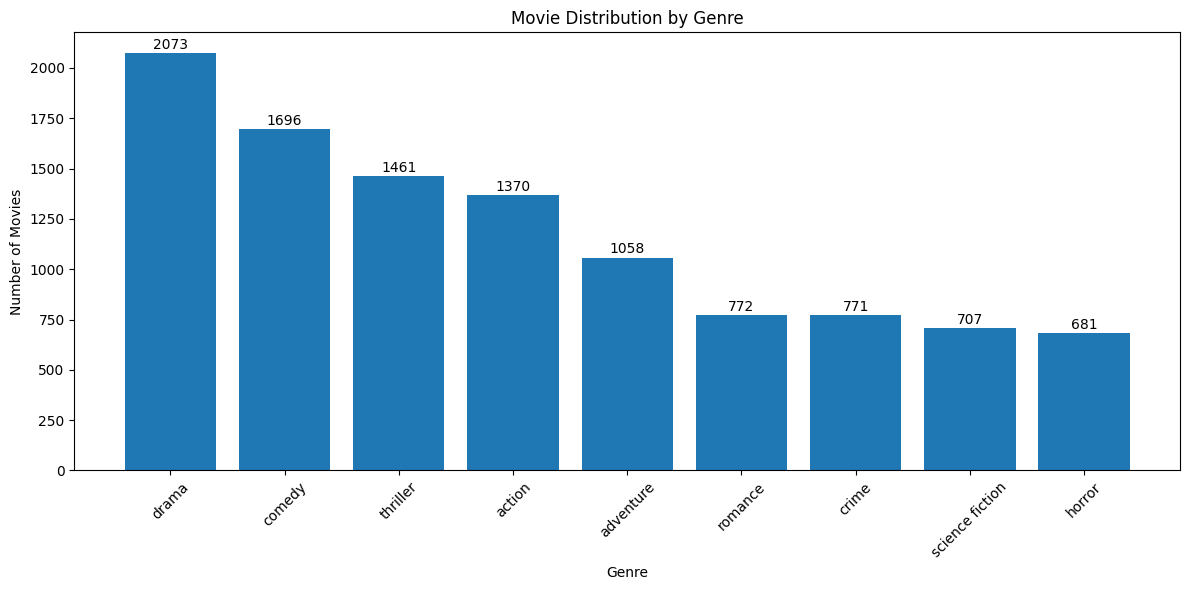

In [43]:

# Cell 3: Explore genre distribution
# ---------------------------------

# List of genre columns
genre_columns = ['drama', 'comedy', 'thriller', 'action', 'adventure', 'romance',
               'crime', 'science fiction', 'horror']

# Count movies by genre (a movie can belong to multiple genres)
genre_counts = {genre: final_df[genre].sum() for genre in genre_columns if genre in final_df.columns}

# Create a bar plot of genre distribution
plt.figure(figsize=(12, 6))
bars = plt.bar(genre_counts.keys(), genre_counts.values())
plt.title('Movie Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [44]:

# Cell 4: Function Definitions
# ---------------------------

def find_movie_fuzzy(movie_name, final_df, threshold=80):
    """Find a movie using fuzzy matching to handle typos or partial matches"""
    movie_titles = final_df['title'].tolist()
    match = process.extractOne(movie_name, movie_titles)
    if match[1] >= threshold:
        return match[0]
    return None

def apply_feature_weights(feature_df):
    """Apply weights to different feature categories"""
    # Make a copy to avoid modifying the original
    weighted_features = feature_df.copy()

    # Define feature groups and their weights
    feature_groups = {
        'genres': {
            'columns': ['drama', 'comedy', 'thriller', 'action', 'adventure', 'romance',
                       'crime', 'science fiction', 'horror'],
            'weight': 3.0  # Genres are 3x more important
        },
        'keywords': {
            'columns': [col for col in feature_df.columns if col not in
                       ['title', 'imdb_id'] and col not in ['drama', 'comedy', 'thriller', 'action',
                       'adventure', 'romance', 'crime', 'science fiction', 'horror']],
            'weight': 1.0  # Word features have default weight
        }
    }

    # Apply weights
    for group, config in feature_groups.items():
        valid_columns = [col for col in config['columns'] if col in feature_df.columns]
        weighted_features[valid_columns] = feature_df[valid_columns] * config['weight']

    return weighted_features

def select_optimal_pca_components(feature_matrix, variance_threshold=0.95, plot=True):
    """Select optimal number of PCA components based on explained variance"""
    scaler = StandardScaler()
    feature_matrix_scaled = scaler.fit_transform(feature_matrix)

    # Run PCA with all possible components
    max_components = min(feature_matrix.shape)

    # If dataset is large, limit max_components to avoid memory issues
    if max_components > 500:
        max_components = 500

    pca = PCA(n_components=max_components)
    pca.fit(feature_matrix_scaled)

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find number of components needed to reach variance threshold
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
        plt.axhline(y=variance_threshold, color='r', linestyle='--',
                   label=f'Threshold: {variance_threshold}')
        plt.axvline(x=n_components, color='g', linestyle='--',
                   label=f'Selected Components: {n_components}')
        plt.title(f'Explained Variance by Components')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.legend()
        plt.grid(True)
        plt.show()

    return n_components, scaler

def create_silhouette_scorer():
    """Create a silhouette scoring function for KNN evaluation"""
    def silhouette_scorer(estimator, X, y=None):
        """
        Custom scoring function using silhouette score

        We need to:
        1. Get neighbors from the KNN estimator
        2. Use these neighbors to create clusters
        3. Calculate silhouette score on these clusters
        """
        # Extract the NearestNeighbors model from the pipeline
        if hasattr(estimator, 'named_steps'):
            knn_step = estimator.named_steps['knn']
        else:
            knn_step = estimator

        # Get neighbor indices for each point
        neighbor_indices = knn_step.kneighbors(X, return_distance=False)

        sample_size = min(1000, X.shape[0])
        sample_indices = np.random.choice(X.shape[0], sample_size, replace=False)
        sample_X = X[sample_indices]

        # Find optimal k for KMeans using elbow method
        inertia_values = []
        k_values = range(2, 11)  # Try k from 2 to 10
        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(sample_X)
            inertia_values.append(kmeans.inertia_)

        # Find elbow point using the derivative
        derivatives = np.diff(inertia_values)
        derivatives_2 = np.diff(derivatives)
        optimal_k_idx = np.argmax(derivatives_2) + 1  # +1 due to two diffs
        optimal_k = k_values[optimal_k_idx]

        # Apply KMeans with optimal k
        kmeans = KMeans(n_clusters=optimal_k, random_state=42)
        cluster_labels = kmeans.fit_predict(X)

        # Calculate silhouette score
        silhouette_avg = silhouette_score(X, cluster_labels)
        return silhouette_avg

    return silhouette_scorer

def optimize_parameters(feature_matrix, param_grid=None):
    """Find optimal parameters for the recommendation system"""
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_matrix)

    # Define parameter grid if not provided
    if param_grid is None:
        # Use a smaller grid for large datasets to avoid long computation times
        if feature_matrix.shape[0] > 3000:
            param_grid = {
                'pca__n_components': [50, 100],
                'knn__n_neighbors': [5, 7],
                'knn__metric': ['euclidean', 'cosine']
            }
        else:
            param_grid = {
                'pca__n_components': [50, 100, 150],
                'knn__n_neighbors': [3, 5, 7, 10],
                'knn__metric': ['euclidean', 'manhattan', 'cosine']
            }

    # Create a pipeline
    pipeline = Pipeline([
        ('pca', PCA()),
        ('knn', NearestNeighbors())
    ])

    # Create silhouette scorer
    silhouette_scorer = create_silhouette_scorer()
    scorer = make_scorer(silhouette_scorer)

    # GridSearchCV with KFold for unsupervised learning
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        scoring=scorer,
        verbose=1
    )

    print("Starting parameter optimization. This may take some time...")
    # Set y to zeros because GridSearchCV expects a target (but we don't use it)
    grid_search.fit(scaled_features, np.zeros(len(scaled_features)))

    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    return best_params

def train_recommendation_system(final_df, variance_threshold=0.95, optimize=True):
    """Train the movie recommendation system with all optimizations"""
    print("Step 1: Preparing feature matrix...")
    feature_columns = final_df.drop(['title', 'imdb_id'], axis=1)

    print("Step 2: Applying feature weights...")
    weighted_features = apply_feature_weights(feature_columns)
    feature_matrix = weighted_features.to_numpy()

    print("Step 3: Finding optimal number of PCA components...")
    optimal_components, scaler = select_optimal_pca_components(
        feature_matrix,
        variance_threshold=variance_threshold,
        plot=True
    )
    print(f"Optimal PCA components: {optimal_components}")

    print("Step 4: Standardizing data...")
    feature_matrix_scaled = scaler.transform(feature_matrix)

    print("Step 5: Applying PCA with optimal components...")
    pca = PCA(n_components=optimal_components)
    feature_matrix_reduced = pca.fit_transform(feature_matrix_scaled)

    # Step 6: Optimize parameters (if requested)
    if optimize:
        print("Step 6: Optimizing parameters...")
        best_params = optimize_parameters(feature_matrix)

        # Extract best parameters
        best_n_components = best_params.get('pca__n_components', optimal_components)
        best_n_neighbors = best_params.get('knn__n_neighbors', 5)
        best_metric = best_params.get('knn__metric', 'euclidean')

        # If best components from grid search is different, re-run PCA
        if best_n_components != optimal_components:
            print(f"Updating PCA with optimized components: {best_n_components}")
            pca = PCA(n_components=best_n_components)
            feature_matrix_reduced = pca.fit_transform(feature_matrix_scaled)
    else:
        best_n_neighbors = 5
        best_metric = 'euclidean'

    print(f"Step 7: Creating final KNN model with {best_n_neighbors} neighbors and {best_metric} metric...")
    knn_model = NearestNeighbors(
        n_neighbors=best_n_neighbors,
        metric=best_metric
    )
    knn_model.fit(feature_matrix_reduced)

    model_data = {
        'scaler': scaler,
        'pca': pca,
        'knn_model': knn_model,
        'reduced_features': feature_matrix_reduced,
        'best_n_neighbors': best_n_neighbors,
        'best_metric': best_metric
    }

    print("Training complete!")
    return model_data

def get_recommendations(movie_name, final_df, model_data, k=None):
    """Get movie recommendations using the optimized system"""
    # Try to find the movie with fuzzy matching
    exact_match = final_df[final_df['title'].str.lower() == movie_name.lower()]

    if exact_match.empty:
        fuzzy_match = find_movie_fuzzy(movie_name, final_df)
        if fuzzy_match:
            print(f"Movie '{movie_name}' not found. Using closest match: '{fuzzy_match}'")
            movie_name = fuzzy_match
            matches = final_df[final_df['title'] == fuzzy_match]
        else:
            return f"'{movie_name}' not found in the dataset."
    else:
        matches = exact_match

    # Get the movie index
    movie_index = matches.index[0]

    # Get weighted features
    feature_row = final_df.drop(['title', 'imdb_id'], axis=1).iloc[movie_index]
    weighted_feature_row = apply_feature_weights(pd.DataFrame(feature_row).T).iloc[0]

    # Transform the movie features
    scaler = model_data['scaler']
    pca = model_data['pca']
    knn_model = model_data['knn_model']

    scaled_vector = scaler.transform([weighted_feature_row])
    reduced_vector = pca.transform(scaled_vector)

    # Use default k if not specified
    if k is None:
        k = model_data['best_n_neighbors']

    # Get nearest neighbors
    distances, indices = knn_model.kneighbors(reduced_vector, n_neighbors=k+1)

    # Remove the query movie itself
    mask = indices[0] != movie_index
    filtered_indices = indices[0][mask][:k]
    filtered_distances = distances[0][mask][:k]

    # Get recommended movies with similarity scores
    recommended_movies = []
    max_distance = filtered_distances.max() if len(filtered_distances) > 0 else 1
    for i, idx in enumerate(filtered_indices):
        # Convert distance to similarity score (1 = identical, 0 = completely different)
        similarity = 1 - (filtered_distances[i] / max_distance) if max_distance > 0 else 0

        recommended_movies.append({
            'title': final_df.iloc[idx]['title'],
            'imdb_id': final_df.iloc[idx]['imdb_id'],
            'similarity': similarity
        })

    return recommended_movies

def save_model(model_data, filename='movie_recommender_model.pkl'):
    """Save the trained model to disk"""
    with open(filename, 'wb') as f:
        pickle.dump(model_data, f)
    print(f"Model saved to {filename}")

def load_model(filename='movie_recommender_model.pkl'):
    """Load a trained model from disk"""
    with open(filename, 'rb') as f:
        model_data = pickle.load(f)
    print(f"Model loaded from {filename}")
    return model_data

def evaluate_recommendations(movie_name, final_df, model_data, k=5):
    """Evaluate recommendations by comparing genre overlap"""
    recommendations = get_recommendations(movie_name, final_df, model_data, k)

    if isinstance(recommendations, str):
        return recommendations

    # Get query movie genres
    query_movie = final_df[final_df['title'].str.lower() == movie_name.lower()]
    if query_movie.empty:
        query_movie = final_df[final_df['title'] == find_movie_fuzzy(movie_name, final_df)]

    query_index = query_movie.index[0]

    # Define genre columns
    genre_columns = ['drama', 'comedy', 'thriller', 'action', 'adventure', 'romance',
                    'crime', 'science fiction', 'horror']
    valid_genres = [g for g in genre_columns if g in final_df.columns]

    # Get query movie genres
    query_genres = final_df.loc[query_index, valid_genres]
    query_genres = [g for g, has_genre in zip(valid_genres, query_genres) if has_genre == 1]

    # Calculate genre overlap for each recommendation
    for rec in recommendations:
        rec_index = final_df[final_df['title'] == rec['title']].index[0]
        rec_genres = final_df.loc[rec_index, valid_genres]
        rec_genres = [g for g, has_genre in zip(valid_genres, rec_genres) if has_genre == 1]

        # Calculate overlap (Jaccard similarity)
        if len(query_genres) > 0 or len(rec_genres) > 0:
            overlap = len(set(query_genres) & set(rec_genres)) / len(set(query_genres) | set(rec_genres))
        else:
            overlap = 0

        rec['genre_overlap'] = overlap
        rec['genres'] = rec_genres

    # Calculate average genre overlap
    avg_overlap = np.mean([r['genre_overlap'] for r in recommendations])

    # Print evaluation results
    print(f"\n🎬 Recommendations for '{movie_name}':")
    print(f"Query movie genres: {', '.join(query_genres)}")
    print(f"Average genre overlap: {avg_overlap:.2f} (0-1 scale, higher is better)")

    # Print recommendations with metrics
    for i, rec in enumerate(recommendations, 1):
        genres_str = ', '.join(rec['genres'])
        print(f"{i}. {rec['title']} (IMDb: {rec['imdb_id']}) - Similarity: {rec['similarity']:.2f}, Genre overlap: {rec['genre_overlap']:.2f}")
        print(f"   Genres: {genres_str}")

    return recommendations, avg_overlap


Training the movie recommendation system...
Step 1: Preparing feature matrix...
Step 2: Applying feature weights...
Step 3: Finding optimal number of PCA components...


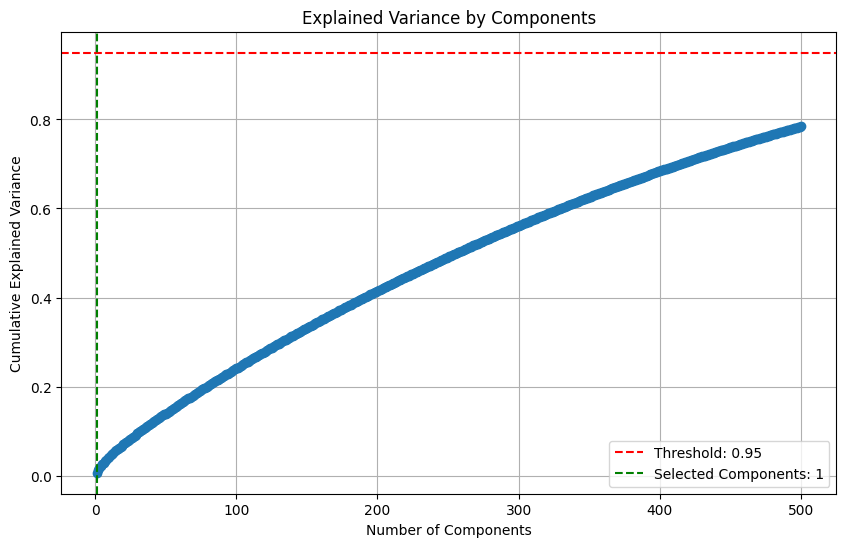

Optimal PCA components: 1
Step 4: Standardizing data...
Step 5: Applying PCA with optimal components...
Step 6: Optimizing parameters...
Starting parameter optimization. This may take some time...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'pca__n_components': 50}
Updating PCA with optimized components: 50
Step 7: Creating final KNN model with 5 neighbors and euclidean metric...
Training complete!
Model saved to movie_recommender_model.pkl


In [45]:

# Cell 5: Train the Recommendation System
# --------------------------------------

# Train the recommendation system
print("Training the movie recommendation system...")
model_data = train_recommendation_system(final_df, variance_threshold=0.95, optimize=True)

# Optionally save the trained model to disk
save_model(model_data)


In [46]:

# Cell 6: Test the Recommendation System
# -------------------------------------

# Test with some example movies
test_movies = ["Southpaw", "The Matrix", "  ", "The Godfather"]

for movie in test_movies:
    print("\n" + "="*60)
    evaluate_recommendations(movie, final_df, model_data, k=5)



🎬 Recommendations for 'Southpaw':
Query movie genres: drama, action
Average genre overlap: 0.33 (0-1 scale, higher is better)
1. Adrift (IMDb: tt6306064) - Similarity: 0.08, Genre overlap: 0.00
   Genres: thriller, adventure, romance
2. Rogue One: A Star Wars Story (IMDb: tt3748528) - Similarity: 0.07, Genre overlap: 0.25
   Genres: action, adventure, science fiction
3. All Is Lost (IMDb: tt2017038) - Similarity: 0.04, Genre overlap: 0.67
   Genres: drama, action, adventure
4. King Richard (IMDb: tt9620288) - Similarity: 0.03, Genre overlap: 0.50
   Genres: drama
5. Chicago (IMDb: tt0299658) - Similarity: 0.00, Genre overlap: 0.25
   Genres: drama, comedy, crime


🎬 Recommendations for 'The Matrix':
Query movie genres: action, science fiction
Average genre overlap: 0.65 (0-1 scale, higher is better)
1. Doomsday (IMDb: tt0483607) - Similarity: 0.05, Genre overlap: 0.67
   Genres: thriller, action, science fiction
2. Jupiter Ascending (IMDb: tt1617661) - Similarity: 0.02, Genre overlap

In [48]:
from google.colab import files
files.download("movie_recommender_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>